# Non-Food / Food Image Classification - Business Case Study - Tensorflow 2.0.0
---
Author: Bhaveshkumar Thaker

---

## Install Required Libraries

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 48.8MB/s 
     |████████████████████████████████| 3.8MB 27.1MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

## Import Libraries

In [0]:
import os, os.path, sys, random
from zipfile import ZipFile
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

In [3]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [4]:
seed = 321

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.figure(figsize=(14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS
sns.set(rc={
    'figure.figsize': (14, 11),
    'figure.facecolor': 'whitesmoke',
    'axes.facecolor': 'whitesmoke',
    'grid.color': 'slategrey',
    })
sns.color_palette(palette=list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Food-5K

This is a dataset containing 2500 food and 2500 non-food images, for the task of food/non-food classification in our paper “Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model”. The whole dataset is divided in three parts: training, validation and evaluation. The naming convention is as follows:

`{ClassID}_{ImageID}.jpg`

*   ClassID: 0 or 1; 0 means non-food and 1 means food.
*   ImageID: ID of the image within the class.

Access:
*   URL: https://mmspg.epfl.ch/downloads/food-image-datasets/
*   protocol: FTP (we recommend to use FileZilla)
*   server: tremplin.epfl.ch
*   username: FoodImage@grebvm2.epfl.ch  (username includes @grebvm2.epfl.ch)
*   password: Cahc1moo
*   File: Food-5K.zip - The total fize size of the Food-5K dataset is about 446.9 MB.

In [0]:
INPUT_DATASET = 'Food-5K.zip'

BASE_PATH = "dataset"

TRAIN = "training"
VAL = "validation"
TEST = "evaluation"

CLASSES = ["non_food", "food"]

In [6]:
if not os.path.exists(INPUT_DATASET) :
    !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
        --ftp-password Cahc1moo ftp://tremplin.epfl.ch/Food-5K.zip

--2019-11-02 12:55:18--  ftp://tremplin.epfl.ch/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.50.75, 2001:620:618:132:1:80b2:324b:1
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.50.75|:21... connected.
Logging in as FoodImage@grebvm2.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD not needed.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M   113MB/s    in 4.4s    

2019-11-02 12:55:24 (96.0 MB/s) - ‘Food-5K.zip’ saved [446919921]



## Extract Dataset Files

In [7]:
if os.path.exists(TRAIN) :
    print('Zip file is extracted already')
else :
    print('Extracting the Zip file...')
    with ZipFile(INPUT_DATASET, 'r') as zip:
        zip.extractall()
        zip.close()
        print('Zip file extracted successfully')

Extracting the Zip file...
Zip file extracted successfully


## Build Dataset

In [8]:
for split in (TRAIN, VAL, TEST):
    # grab all image paths in the current split
    print("Processing '{} split' ... ".format(split))
    for root, dirs, files in os.walk(split, topdown=True) :
        for imgfile in files:
            if imgfile.startswith('.'):
                continue;
            # extract class label from the file
            label = CLASSES[int(imgfile.split('_')[0])]
            # construct the path to the output directory
            dirPath = os.path.sep.join([BASE_PATH, split, label])
            # if the output directory does not exist, create it
            if not os.path.exists(dirPath) :
                os.makedirs(dirPath)
            # construct the path to the output image file and copy it
            pathToCopyFile = os.path.sep.join([dirPath, imgfile])
            shutil.copy2(os.path.sep.join([root, imgfile]), pathToCopyFile)

Processing 'training split' ... 
Processing 'validation split' ... 
Processing 'evaluation split' ... 


## Check Image Size

In [0]:
image_size = 224
allpaths = ['dataset/training', 'dataset/validation', 'dataset/evaluation']
category = {'non_food' : 0, 'food': 1}

In [10]:
for path in allpaths:
    for root, dirs, files in os.walk(path, topdown=True):
        for imgfile in files:
            try:
                img = Image.open(os.path.join(root, imgfile))
                img2arr = np.asarray(img, dtype=np.float32)
                #print('{}: Shape of image {} is {}'.format(os.path.basename(root), imgfile, img2arr.shape))
                print('{}: Shape of image "{}" is {}'.format(root, imgfile, img2arr.shape))
            except:
                print('Bad file: ' + os.path.join(root, imgfile))
            
            # checking dimensions of only 1 file each from folder
            break;

dataset/training/food: Shape of image "1_1383.jpg" is (640, 640, 3)
dataset/training/non_food: Shape of image "0_298.jpg" is (348, 516, 3)
dataset/validation/food: Shape of image "1_192.jpg" is (384, 512, 3)
dataset/validation/non_food: Shape of image "0_298.jpg" is (480, 510, 3)
dataset/evaluation/food: Shape of image "1_192.jpg" is (512, 512, 3)
dataset/evaluation/non_food: Shape of image "0_298.jpg" is (468, 640, 3)


## Display Images from Dataset

In [11]:
no_of_images = 5

for path in allpaths :
    for root, dirs, files in os.walk(path, topdown=True) :
        img_displayed = 0
        for imgfile in files:
            img = Image.open(root + os.sep + imgfile)
            imgarr = np.asarray(img)
            img.close()

            plt.subplot(no_of_images, no_of_images, img_displayed + 1)
            plt.imshow(X=imgarr)
            plt.title(root + os.sep + imgfile, fontsize=10)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])

            img_displayed = img_displayed + 1
            if(img_displayed >= (no_of_images * no_of_images)):
                print('\x1b[1;37;40m'+ '\n==================== ' + root + ' ====================\n' +'\x1b[0m')
                plt.tight_layout()
                plt.show();
                break;

Output hidden; open in https://colab.research.google.com to view.

## Data curation

In [0]:
train_feature, val_feature, test_feature = [], [], []
train_target, val_target, test_target = [], [], []

for path in allpaths :
    num_image = 0
    for root, dir, files in os.walk(path, topdown=True) :
        for imgfile in files :
            img = Image.open( os.path.join(root, imgfile) )
            img = img.resize(size = (image_size, image_size))
            img2arr = np.array(img, dtype=np.float32) / 255.0
            img.close()
            if len(img2arr.shape) == 3:
                img2arr = np.dstack([img2arr])
                if path.endswith(TRAIN) :
                    train_feature.append(img2arr)
                    train_target.append(category.get( os.path.basename(root) ))
                if path.endswith(VAL) :
                    val_feature.append(img2arr)
                    val_target.append(category.get( os.path.basename(root) ))
                if path.endswith(TEST) :
                    test_feature.append(img2arr)
                    test_target.append(category.get( os.path.basename(root) ))

In [0]:
train_feature, train_target = np.asarray(train_feature, dtype=np.float32), np.asarray(train_target, np.int)
val_feature, val_target = np.asarray(val_feature, dtype=np.float32), np.asarray(val_target, np.int)
test_feature, test_target = np.asarray(test_feature, dtype=np.float32), np.asarray(test_target, np.int)

In [14]:
(train_feature.shape, train_target.shape), (val_feature.shape, val_target.shape), (test_feature.shape, test_target.shape)

(((2992, 224, 224, 3), (2992,)),
 ((997, 224, 224, 3), (997,)),
 ((1000, 224, 224, 3), (1000,)))

## Verify Data
Displaying a sample of the labels and images from the ndarray.

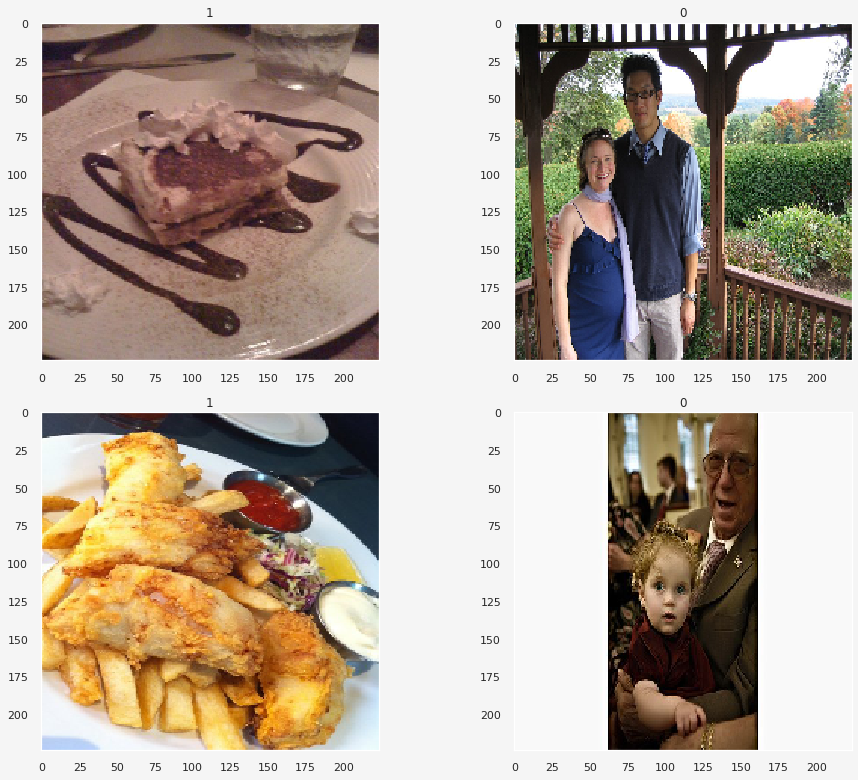

In [15]:
plt.subplot(2, 2, 1)
plt.imshow(train_feature[20], cmap = plt.cm.gray)
plt.title(train_target[20])
plt.grid(False)
plt.subplot(2, 2, 2)
plt.imshow(train_feature[2991], cmap = plt.cm.gray)
plt.title(train_target[2991])
plt.grid(False)
plt.subplot(2, 2, 3)
plt.imshow(val_feature[7], cmap = plt.cm.gray)
plt.title(val_target[7])
plt.grid(False)
plt.subplot(2, 2, 4)
plt.imshow(test_feature[623], cmap = plt.cm.gray)
plt.title(test_target[623])
plt.grid(False)

plt.tight_layout()
plt.show()

## Randomize the data

In [0]:
idx = np.random.permutation(len(train_target))

train_feature, train_target = train_feature[idx], train_target[idx]

## Train Convolutional Neural Network (CNN) Model

In [17]:
# Set the input and output sizes
output_size = 1

# Filters
filters_128 = 128
filters_256 = 256
filters_512 = 512

# Kernel Size
kernel_size = (3, 3)

# Input Shape
input_shape = (image_size, image_size, 3)

# Pool Size
pool_size = (2, 2)

# Useing same hidden layer size for all hidden layers.
hidden_layer_size = 256

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=filters_128, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='valid'),
    tf.keras.layers.Conv2D(filters=filters_256, kernel_size=kernel_size, padding='same', activation='relu',),
    tf.keras.layers.Conv2D(filters=filters_256, kernel_size=kernel_size, padding='same', activation='relu',),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='valid'),
    tf.keras.layers.Conv2D(filters=filters_512, kernel_size=kernel_size, padding='same', activation='relu',),
    tf.keras.layers.Conv2D(filters=filters_512, kernel_size=kernel_size, padding='same', activation='relu',),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='sigmoid'),
    ])

# Choose the optimizer, the loss function and the metrics
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 512)       1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 512)       2

In [18]:
# Set a maximum number of training epochs
# max_epochs = 100
max_epochs = 25

# Set the batch size
batch_size = 75

# Set an early stopping mechanism
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        patience=3, verbose=0, mode='auto')
model_checkpoint_save = \
    tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'
        , monitor='val_loss', save_best_only=True, mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='min',
    )

# Fit the model
history = model.fit(
    train_feature,
    train_target,
    batch_size=batch_size,
    epochs=max_epochs,
    #callbacks=[early_stopping, model_checkpoint_save, reduce_lr_loss],
    callbacks=[early_stopping],
    validation_data=(val_feature, val_target),
    verbose=2,
    )

Train on 2992 samples, validate on 997 samples
Epoch 1/25
2992/2992 - 188s - loss: 1.2527 - accuracy: 0.6026 - val_loss: 0.4914 - val_accuracy: 0.7543
Epoch 2/25
2992/2992 - 143s - loss: 0.5205 - accuracy: 0.7513 - val_loss: 0.5241 - val_accuracy: 0.7673
Epoch 3/25
2992/2992 - 143s - loss: 0.4441 - accuracy: 0.8152 - val_loss: 0.4314 - val_accuracy: 0.7964
Epoch 4/25
2992/2992 - 143s - loss: 0.3929 - accuracy: 0.8305 - val_loss: 0.3942 - val_accuracy: 0.8195
Epoch 5/25
2992/2992 - 143s - loss: 0.3874 - accuracy: 0.8416 - val_loss: 0.3691 - val_accuracy: 0.8335
Epoch 6/25
2992/2992 - 143s - loss: 0.3532 - accuracy: 0.8570 - val_loss: 0.4088 - val_accuracy: 0.8335
Epoch 7/25
2992/2992 - 143s - loss: 0.3147 - accuracy: 0.8740 - val_loss: 0.3168 - val_accuracy: 0.8656
Epoch 8/25
2992/2992 - 143s - loss: 0.2770 - accuracy: 0.8914 - val_loss: 0.2798 - val_accuracy: 0.8897
Epoch 9/25
2992/2992 - 143s - loss: 0.2357 - accuracy: 0.9084 - val_loss: 0.2833 - val_accuracy: 0.8917
Epoch 10/25
2992/

## Plot Model Performances

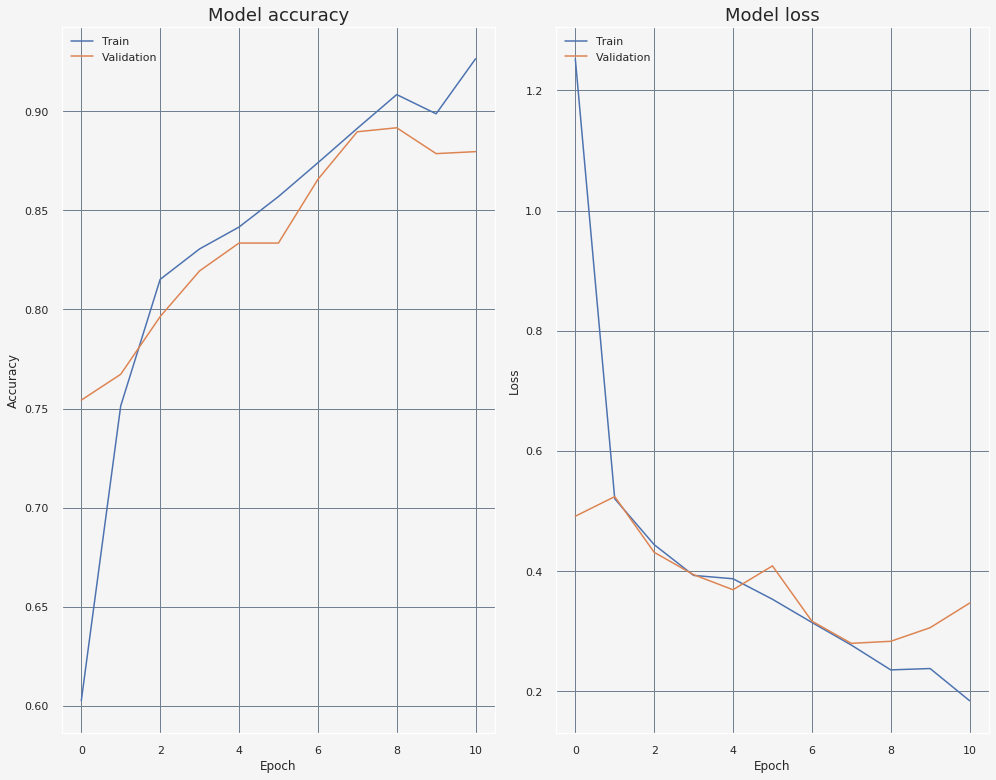

In [19]:
plt.subplot(1, 2, 1)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

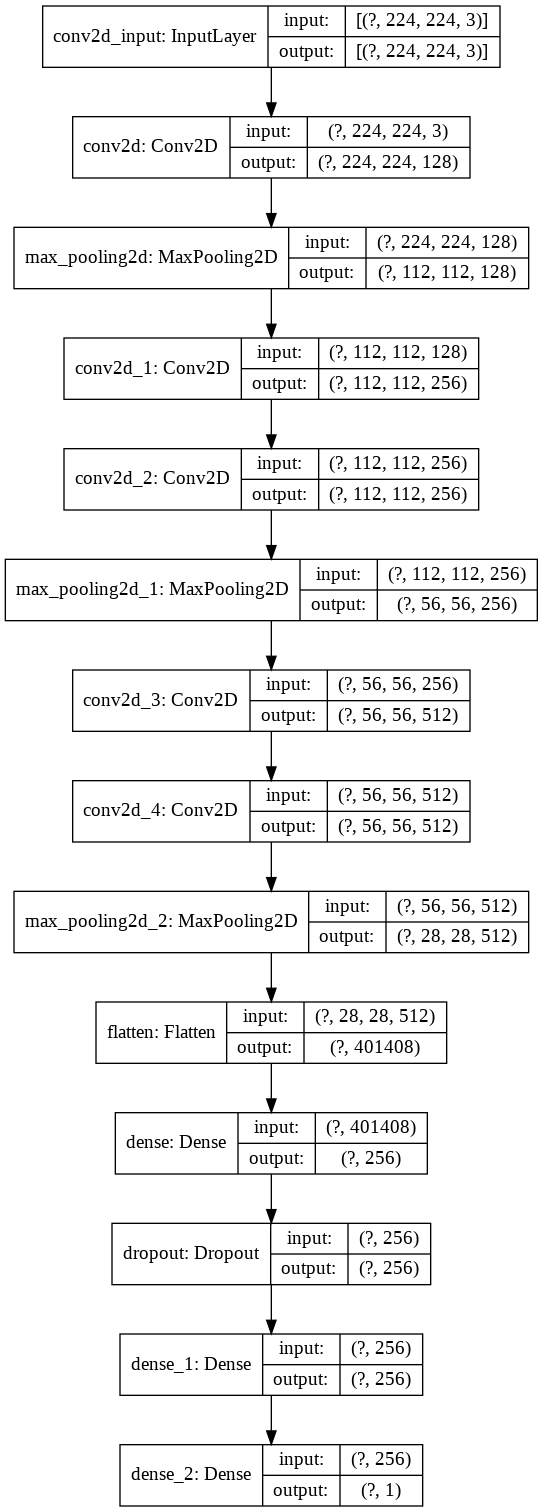

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

## Calculate Accuracy on Test Data

In [21]:
test_loss, test_accuracy = model.evaluate(test_feature, test_target, verbose = 0)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy * 100.0))


Test loss: 0.46. Test accuracy: 85.80%


## Predicting Test Data

In [0]:
predictions = model.predict_classes(test_feature)

In [23]:
predictions.shape, test_target.shape

((1000, 1), (1000,))

In [24]:
print(classification_report(test_target, predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       500
           1       0.92      0.79      0.85       500

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



In [25]:
print(confusion_matrix(test_target, predictions))

[[464  36]
 [106 394]]


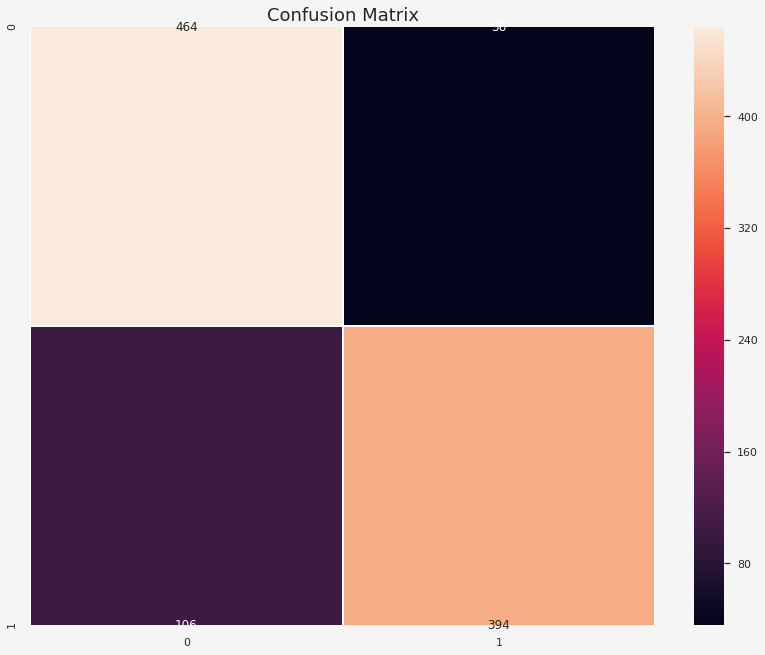

In [26]:
sns.heatmap(confusion_matrix(test_target, predictions), annot=True, fmt="d", linewidths=0.75)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()